In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import operator
import itertools
import re

from networkx.algorithms import bipartite
from collections import Counter
from networkx.algorithms.community import greedy_modularity_communities
from mpl_toolkits.basemap import Basemap as Basemap
from networkx.algorithms.community import k_clique_communities
import networkx.algorithms.community as nx_comm

map = Basemap()
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Introduction

The idea of this project was born following what happened in the last days in Egypt, along the Suez Canal. The running aground of the ship Ever Given, which lasted about a week, has literally blocked the transit of one of the most important nodes of maritime trade: it is estimated that 12% of world trade transits along that channel. 

Industry- and trade-related sectors suffered heavy losses, exacerbating an already fragile situation due to the effects of the pandemic. On the contrary, the services sector, where we can find more "intangible" services, may be less affected by events of this magnitude, but this does not mean that they are exempt from risks, aka black swans, unexpected events whose consequences may be decidedly significant.

What would be a black swan for the services sector? In my opinion its "fuel" is provided by continuous technological progress, by an increasingly interconnected and real time society: what would happen if this connection "physically" were to break down?

The network that allows internet connection is physically provided by submarine cables that allow data transfer through fiber optics. These cables are born and connected on land, in precise locations, from which then, through the most standard connections, arrive in homes and offices as we are accustomed. As can be read [here](https://en.wikipedia.org/wiki/Submarine_communications_cable), some event of this type already took place in the past years, with (luckly) not so significative damages.

Having said that, the questions I asked myself are: 
- What are the most important arrival/departure points for these cables? 
- Which of these is a crucial point to allow the proper functioning of the internet connection?
- Could be possible an event as the one happend in the Suez Canal, in the "digital era"?

# 1.0 Data retrival

In order to answer the previous questions, I retrieved two datasets from the following [source](https://hub.arcgis.com/datasets/Story::telecomcables-2018?geometry=-174.023%2C-66.926%2C174.024%2C82.357&selectedAttribute=Shape__Length), where there are informations related to:

- submarine cables
- cities affected by each cables

In a hypothetical more in-depth job, this data retrieval step can be automated using a simple scraper.

In [2]:
city = pd.read_csv('Submarine_Cables_and_Terminals__2018_city.csv')
cable = pd.read_csv('Submarine_Cables_and_Terminals__2018_cable.csv')

In [3]:
city = city.drop(columns='OBJECTID')
cable = cable.drop(columns=['OBJECTID','Shape__Length'])

In [4]:
city = city.rename(columns={'Y':'latitude','X':'longitude'})

In [5]:
city.head(1)

longitude  latitude             Name  city_id  cable_id
0 -68.956943   12.1689  Mahuma, Curaçao    17242      1727

In [6]:
cable.head(1)

Name                      Text_ID  cable_id  \
0  Coral Sea Cable System (CSCS)  coral-sea-cable-system-cscs      1934   

     length ReadyForServiceDate                owners url  
0  4,000 km             Q4 2019  Vocus Communications

After a first round of data preparation i've decided to merge both datasets into a new one.

In [7]:
df = pd.merge(city,cable,on='cable_id',suffixes=['_city','_cable'],how='inner')
df = df.drop_duplicates()

In [8]:
df2 = pd.DataFrame(df.groupby('cable_id')['Name_city'].unique())

# 2.0 Data Preparation

In order to find the correct relatioship between cities bounded by the same cables, i've created a **list of adjacencies** useful later for the creation of the network

In [9]:
df4 = []

In [10]:
for i in range(df2.shape[0]):
    coppie = df2.iloc[i].Name_city.tolist()
    df3 = pd.DataFrame([(p1, p2) for p1 in coppie for p2 in coppie if p1 != p2],columns=['source','target'])
    df3['cable_id'] = int(df2.iloc[i].name)
    df4.append(df3)
df4 = pd.concat(df4)

In [11]:
df5 = pd.merge(df4,df[['cable_id','Name_cable','length','ReadyForServiceDate','owners','Name_city']],left_on=['cable_id','source'],right_on=['cable_id','Name_city'],how='left')
df5 = df5.drop(columns=['Name_city'])

In order to retrive all the informations possible from the original dataset i've decided to:
- edit the "length" field and transform it into a numerical --> this could be a possibile weight for a weighted graph
- retrive information about how many cities every cable "touches" : the more it touches, the more important is the cable --> this could be an attribute to the edges
- retrive information about how many different cables touch every city: the more a city is reached by different cable the most important it should be --> this could be an attribute to the nodes

In [12]:
df5['length'] = df5['length'].str.replace(r'\D','')
df5['length'] = pd.to_numeric(df5['length'])

C:\Users\daniele\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [13]:
df5['freq_cable'] = df5.cable_id.map(df5.groupby('cable_id')['source'].nunique())
df5['freq_city'] = df5.source.map(df5.groupby('source')['target'].nunique())

Ater these transformations the final dataset is created.

In [14]:
df6 = pd.merge(df5,city,left_on=['source','cable_id'],right_on=['Name','cable_id'],how='left')

In [15]:
df6.head(1)

source        target  cable_id  \
0  Grover Beach, California, United States  Shima, Japan      1007   

                  Name_cable   length ReadyForServiceDate owners  freq_cable  \
0  Pacific Crossing-1 (PC-1)  20900.0       December 1999    NTT           4   

   freq_city  longitude   latitude                                     Name  \
0          7 -120.62142  35.120635  Grover Beach, California, United States   

   city_id  
0     5748

In [16]:
df6.shape

(14245, 13)

# 3.0 Modelling

Let's start by building the simple network structures. I've take the following decison in order to answer my original question: which cities are more important for the internet connection?
- graph type: undirected
- nodes: cities as start and endpoint of the cables
- edges: cables between cities

In [17]:
g = nx.from_pandas_edgelist(df6,source='source',target='target',edge_attr=True, create_using=nx.Graph())

## 3.1 Network Evaluation

Having given this structure what emerges on initial analysis?

In [18]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 1071
Number of edges: 6535
Average degree:  12.2035


From a first look emerges that the average degree is segnaling us that every node as in mean around 12 link: every city in the dataset has around 12 cables connections. Maybe the mean could not be the right metric to use: let's have a look at the degree distribution!

Text(0, 0.5, 'Counts')

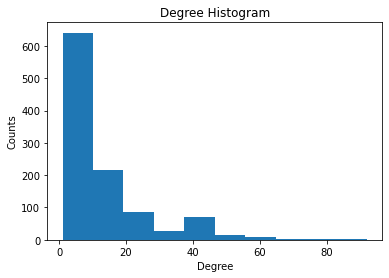

In [19]:
degree = [g.degree(n) for n in g.nodes()]
plt.title('Degree Histogram')
plt.hist(degree)
plt.xlabel('Degree')
plt.ylabel('Counts')

The degreee distribution reflects one of the typical element found in most of other **real** networks: Hubs, few and important nodes. What about density?

In [20]:
nx.density(g)

0.011405185127010305

This value said that the proportion between nodes and link is highly skewed: the density is low.

What about che connectivity between the nodes? Let's see the average clustering coefficient!

In [21]:
nx.average_clustering(g)

0.6941312241731954

This value tells us that the nodes in the network are quite connected to each other!

Having concluded this phase of macro analysis of the network, we can draw some considerations:
- we are faced with a network in which the nodes are well connected to each other
- we are faced with a network whose links are concentrated in some subset of nodes, given the low density value and the presence of significant hubs.

At this point we are going to analyze the centrality of the nodes to identify those most important for the entire network, those on which it is good to pay attention to maintain a positive health of the Internet network.

## 3.2 Nodes Evaluation

### 3.2.1 Degree Centrality

In [22]:
degc = nx.degree_centrality(g)
sorted(degc.items(), key=operator.itemgetter(1), reverse=True)[0:5]

[('Mumbai, India', 0.08598130841121496),
 ('Fujairah, United Arab Emirates', 0.08504672897196262),
 ('Jeddah, Saudi Arabia', 0.08317757009345794),
 ('Djibouti City, Djibouti', 0.07196261682242991),
 ('Karachi, Pakistan', 0.07009345794392524)]

From the degree centrality results is visible how the top 5 nodes are all located in the area around the Indian Ocean, from Saudi Arabia to India. The nodes in this area presents the highest number of link connected.

### 3.2.2 Betweenness Centrality

In [23]:
degc = nx.betweenness_centrality(g)
sorted(degc.items(), key=operator.itemgetter(1), reverse=True)[0:5]

[('Mazara del Vallo, Italy', 0.08635467765783147),
 ('Hollywood, Florida, United States', 0.0730330318447739),
 ('Makaha, Hawaii, United States', 0.050753249585698205),
 ('Manado, Indonesia', 0.03981208906466448),
 ('Medan, Indonesia', 0.038281766826796036)]

From the betweenness centrality results is visible instead which are the most important nodes in terms of network connection, i.e. the nodes that act as "connectors" for other nodes, lying on a large number of paths (cables). It's interesting to note that the most important node in this section lies in Italy and it can be seen as a connector between the Mediterranean Sea cables.

## 3.2.3 Closeness Centrality

In [24]:
degc = nx.closeness_centrality(g)
sorted(degc.items(), key=operator.itemgetter(1), reverse=True)[0:5]

[('Mazara del Vallo, Italy', 0.22871337813714168),
 ('Fujairah, United Arab Emirates', 0.22533753491740524),
 ('Mersing, Malaysia', 0.22378917805814683),
 ('Djibouti City, Djibouti', 0.22337987000499981),
 ('Shanghai, China', 0.2213555848214475)]

Also from the closeness centrality results is visibile that the "Mazara del Vallo" node is important in terms of proximity to other nodes. After this node is visibile (again) the nodes of the Indian Ocean area, as seen previously in the degree centrality.

## 3.2.4 Eigenvector centrality

In [25]:
degc = nx.eigenvector_centrality(g)
sorted(degc.items(), key=operator.itemgetter(1), reverse=True)[0:5]

[('Fujairah, United Arab Emirates', 0.18552277259752556),
 ('Mumbai, India', 0.1850978225340618),
 ('Jeddah, Saudi Arabia', 0.18418439734098807),
 ('Karachi, Pakistan', 0.17367566206842933),
 ('Djibouti City, Djibouti', 0.1709986525444857)]

## 3.2.5 PageRank

In [26]:
degc = nx.pagerank(g)
sorted(degc.items(), key=operator.itemgetter(1), reverse=True)[0:5]

[('Mumbai, India', 0.004007598570605169),
 ('Fujairah, United Arab Emirates', 0.0039597377925820135),
 ('Jeddah, Saudi Arabia', 0.003854658233001672),
 ('Djibouti City, Djibouti', 0.0034799348840263695),
 ('Karachi, Pakistan', 0.0032309030693552306)]

As for the spectral centrality metrics, thus based on the eigenvalues of the matrices, I used the classic eigenvector centrality and its normalized version (PageRank) to determine the influence of each node (city) in the network. Both results confirm that the most important nodes are found in the area of the Indian Ocean, between Saudi Arabia and India. 

## 3.2.6 Bivariate Analysis

In [27]:
connectivity = list(g.degree())
connectivity_values = [n[1] for n in connectivity]
centrality = list(nx.eigenvector_centrality(g).values())

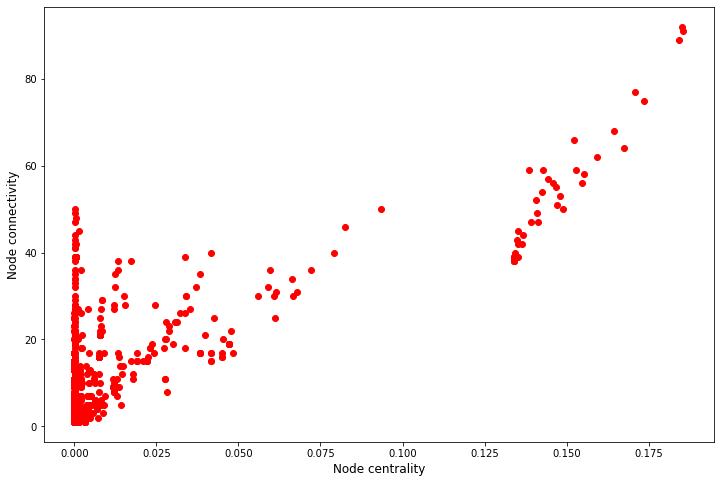

In [28]:
plt.figure(figsize = (12,8))
plt.plot(centrality, connectivity_values,'ro')
plt.xlabel('Node centrality', fontsize='large')
plt.ylabel('Node connectivity', fontsize='large')
plt.show()

In [29]:
deg = pd.DataFrame(list(g.degree()))
deg = deg.sort_values(by=1,ascending=False)

In [30]:
degc = nx.eigenvector_centrality(g)
degc = pd.DataFrame(degc.items())

In [31]:
val = pd.merge(deg,degc,on=0)
val.columns = ['city','degree','centrality']

In [32]:
influencer = val[(val['degree']>50) & (val['centrality']>0.01)]

In [33]:
influencer

city  degree  centrality
0                    Mumbai, India      92    0.185098
1   Fujairah, United Arab Emirates      91    0.185523
2             Jeddah, Saudi Arabia      89    0.184184
3          Djibouti City, Djibouti      77    0.170999
4                Karachi, Pakistan      75    0.173676
5                      Suez, Egypt      68    0.164321
6                 Medan, Indonesia      66    0.152242
7                  Satun, Thailand      64    0.167516
8                  Tuas, Singapore      62    0.159391
9                Mersing, Malaysia      59    0.142857
10                 Shanghai, China      59    0.152961
11                Penmarch, France      59    0.138649
12                  Chania, Greece      58    0.155384
13              Sesimbra, Portugal      57    0.144214
14           Batangas, Philippines      56    0.145907
15               Alexandria, Egypt      56    0.154746
16                Fangshan, Taiwan      55    0.146667
17                Toucheng, Taiwan      54    0.142432
18                Penang, Malaysia      53    0.147979
19         Mazara del Vallo, Italy      52    0.140767
20              Keoje, Korea, Rep.      51    0.147114

What emerged from comparing the centrality and degree of each node? 

From this bivariate comparison, a clear division emerges between the most central and connected nodes and the least. From the "influencer" table above emerges also a peculiarity in my opinion: among the most influential nodes we do not find any point belonging to the American continent. From this analysis to dominate the network of the Internet are nodes belonging to the Mediterranean Sea basin and Southeast Asia.

## 3.3 Communities Detection

At this point it was deemed interesting to perform a community detection exercise, in order to identify that set of similar nodes (cities). In this case it could be mainly a matter of identifying explicit communities, dictated for example by being on the route of a single cable. 

In [34]:
c = list(greedy_modularity_communities(g))

How many communities has been found?

In [35]:
len(c)

107

What is the value of modularity of the communities?

In [36]:
nx_comm.modularity(g,c)

0.7834488414745182

The optimization algorithm satisfactorily manages to partition the network with a decidedly positive modularity value. Now let's try to analyze how this communities are composed.

In [37]:
comm = pd.DataFrame(c)
comm['community_member'] = 0

for i in range(comm.shape[0]):
    comm['community_member'].iloc[i] = i

comm_2 = comm.T.unstack().to_frame().sort_index(level=1)
comm_3 = comm_2.reset_index()
comm_3 = comm_3.drop(columns='level_1')
comm_3.columns = ['community_member','Name']

C:\Users\daniele\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [38]:
df7 = pd.merge(df6,comm_3,on='Name',how='left')

In [39]:
df7.head(1)

source        target  cable_id  \
0  Grover Beach, California, United States  Shima, Japan      1007   

                  Name_cable   length ReadyForServiceDate owners  freq_cable  \
0  Pacific Crossing-1 (PC-1)  20900.0       December 1999    NTT           4   

   freq_city  longitude   latitude                                     Name  \
0          7 -120.62142  35.120635  Grover Beach, California, United States   

   city_id  community_member  
0     5748                 1

In [40]:
df7.groupby('community_member')['length','freq_cable','freq_city'].median()

C:\Users\daniele\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


length  freq_cable  freq_city
community_member                                
0                 25000.0        17.0       40.0
1                  8600.0        15.0       24.0
2                  3498.0        17.0       17.0
3                  5457.0         8.0       14.0
4                  2500.0         4.0        6.0
5                 17000.0        22.0       22.0
6                   402.0        40.0       39.0
7                   437.0         3.0        5.0
8                   966.0        11.0       10.0
9                  1639.0        13.0       12.0
10                11100.0        13.0       12.0
11                 2543.0        14.0       13.0
12                 2400.0        11.0       10.0
13                 1200.0        12.0       11.0
14                 1100.0         7.0        6.0
15                 1253.0         8.0        9.0
16                 1751.0         5.0        4.0
17                    NaN         7.0        6.0
18                 1000.0         7.0        6.0
19                  183.0         7.0        6.0
20                  330.0         4.0        4.0
21                 2730.0         4.0        3.0
22                 1900.0         6.0        5.0
23                  626.0         5.0        4.0
24                   80.0         4.0        3.0
25                 1078.0         5.0        4.0
26                14500.0         4.0        3.0
27                  440.0         3.0        3.0
28                  134.0         4.0        4.0
29                  433.0         3.0        2.0
30                   21.0         4.0        3.0
31                   75.0         4.0        3.0
32                  332.0         3.0        2.0
33                 3500.0         4.0        3.0
34                 8850.0         4.0        3.0
35                 2800.0         4.0        3.0
36                  940.0         4.0        3.0
37                  200.0         4.0        3.0
38                  310.5         2.0        1.5
39                 1205.0         3.0        2.0
40                  461.0         2.0        1.5
41                  598.0         2.0        1.5
42                 1750.0         3.0        2.0
43                  124.0         2.0        1.5
44                    NaN         3.0        2.0
45                 1855.0         3.0        2.0
46                 1364.0         2.0        1.5
47                  410.0         3.0        2.0
48                  254.0         2.0        1.0
49                  137.5         2.0        1.0
50                    5.0         2.0        1.0
51                   15.0         2.0        1.0
52                  110.0         2.0        1.0
53                   93.0         2.0        1.0
54                  230.0         2.0        1.0
55                  115.0         2.0        1.0
56                  130.0         2.0        1.0
57                   20.0         2.0        1.0
58                  110.0         2.0        1.0
59                  208.0         2.0        1.0
60                   35.0         2.0        1.0
61                  190.0         2.0        1.0
62                  299.0         2.0        1.0
63                  210.0         2.0        1.0
64                  241.0         2.0        1.0
65                  212.0         2.0        1.0
66                  239.0         2.0        1.0
67                 1800.0         2.0        1.0
68                  570.0         2.0        1.0
69                  117.0         2.0        1.0
70                   25.0         2.0        1.0
71                   21.0         2.0        1.0
72                  800.0         2.0        1.0
73                 1448.0         2.0        1.0
74                   97.0         2.0        1.0
75                   82.0         2.0        1.0
76                 2714.0         2.0        1.0
77                  187.0         2.0        1.0
78                  213.0         2.0        1.0
79                   11.0         2.0        1.0
8

With this simple group by with respect to the community id identified by the algorithm, the operation of the optimizer is highlighted. This in fact groups the most important nodes, as can be seen from the median values of the fields "freq_cable" and "freq_city", significantly higher in the first communities than in the last ones. A kind of structure is found in the network.

It has been decided to enrich the dataset with the information derived from the biavariate analysis: the cluster of nodes with a high value of degree and centrality has been labeled as "influencer". This informtion could be useful in the next phase.

In [41]:
influencer['influ'] = 'yes'

C:\Users\daniele\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
df8 = pd.merge(df7,influencer,left_on='Name',right_on='city',how='left')

# 4.0 Network Plot

In [43]:
m = Basemap(projection='mill',resolution='l',suppress_ticks=False)
mx, my = m(df8['longitude'].values, df8['latitude'].values)
pos = {}
for count, elem in enumerate (df8['source']):
    pos[elem] = (mx[count], my[count])

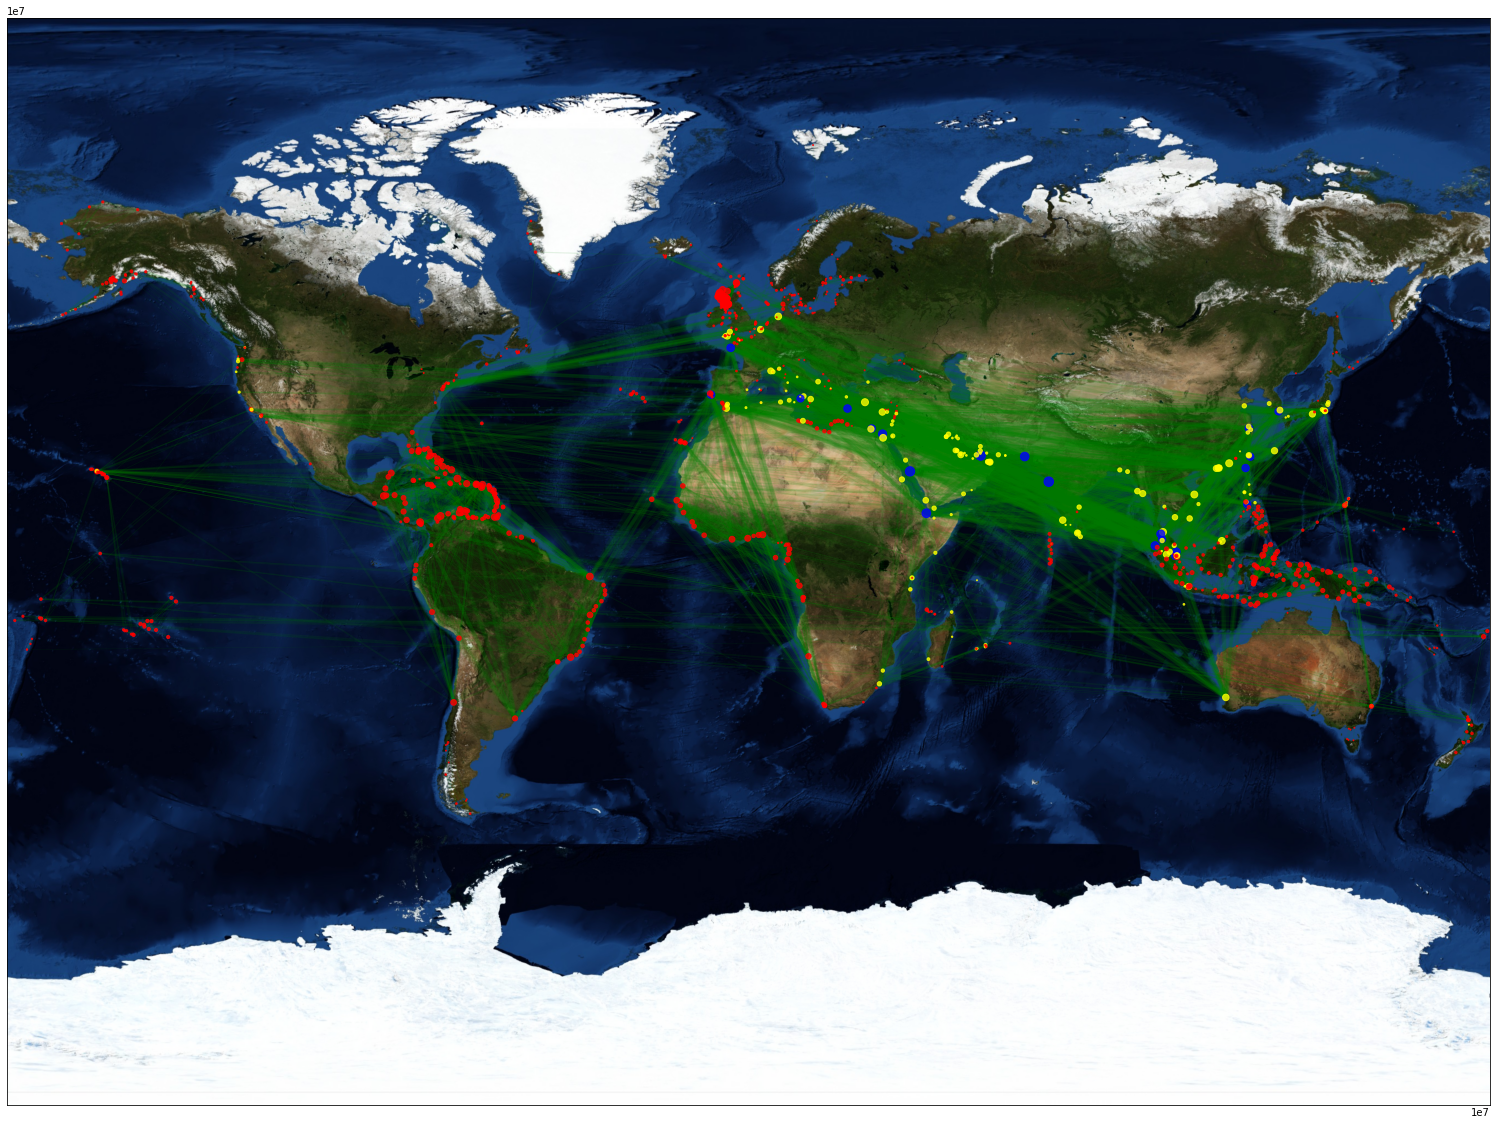

In [44]:
plt.figure(figsize=(30,20))
nx.draw_networkx_nodes(G = g, pos = pos, nodelist = g.nodes(), node_color = ['blue' if df8[df8.Name==s]['influ'].unique()=='yes' else 'yellow' if df8[df8.Name==s]['community_member'].unique()==0 else 'red' for s in g.nodes], alpha = 0.8,node_size = [df8[df8.source==s]['freq_city'].unique()[0] for s in g.nodes])
nx.draw_networkx_edges(G = g, pos = pos, edgelist = g.edges(), edge_color='g',alpha=0.1, arrows = False, width=[float(df8[df8['Name_cable']==s]['freq_cable'].max())/10 for s in df8.Name_cable])
m.bluemarble()

Below the same plot with another background for better identifing some cliques.

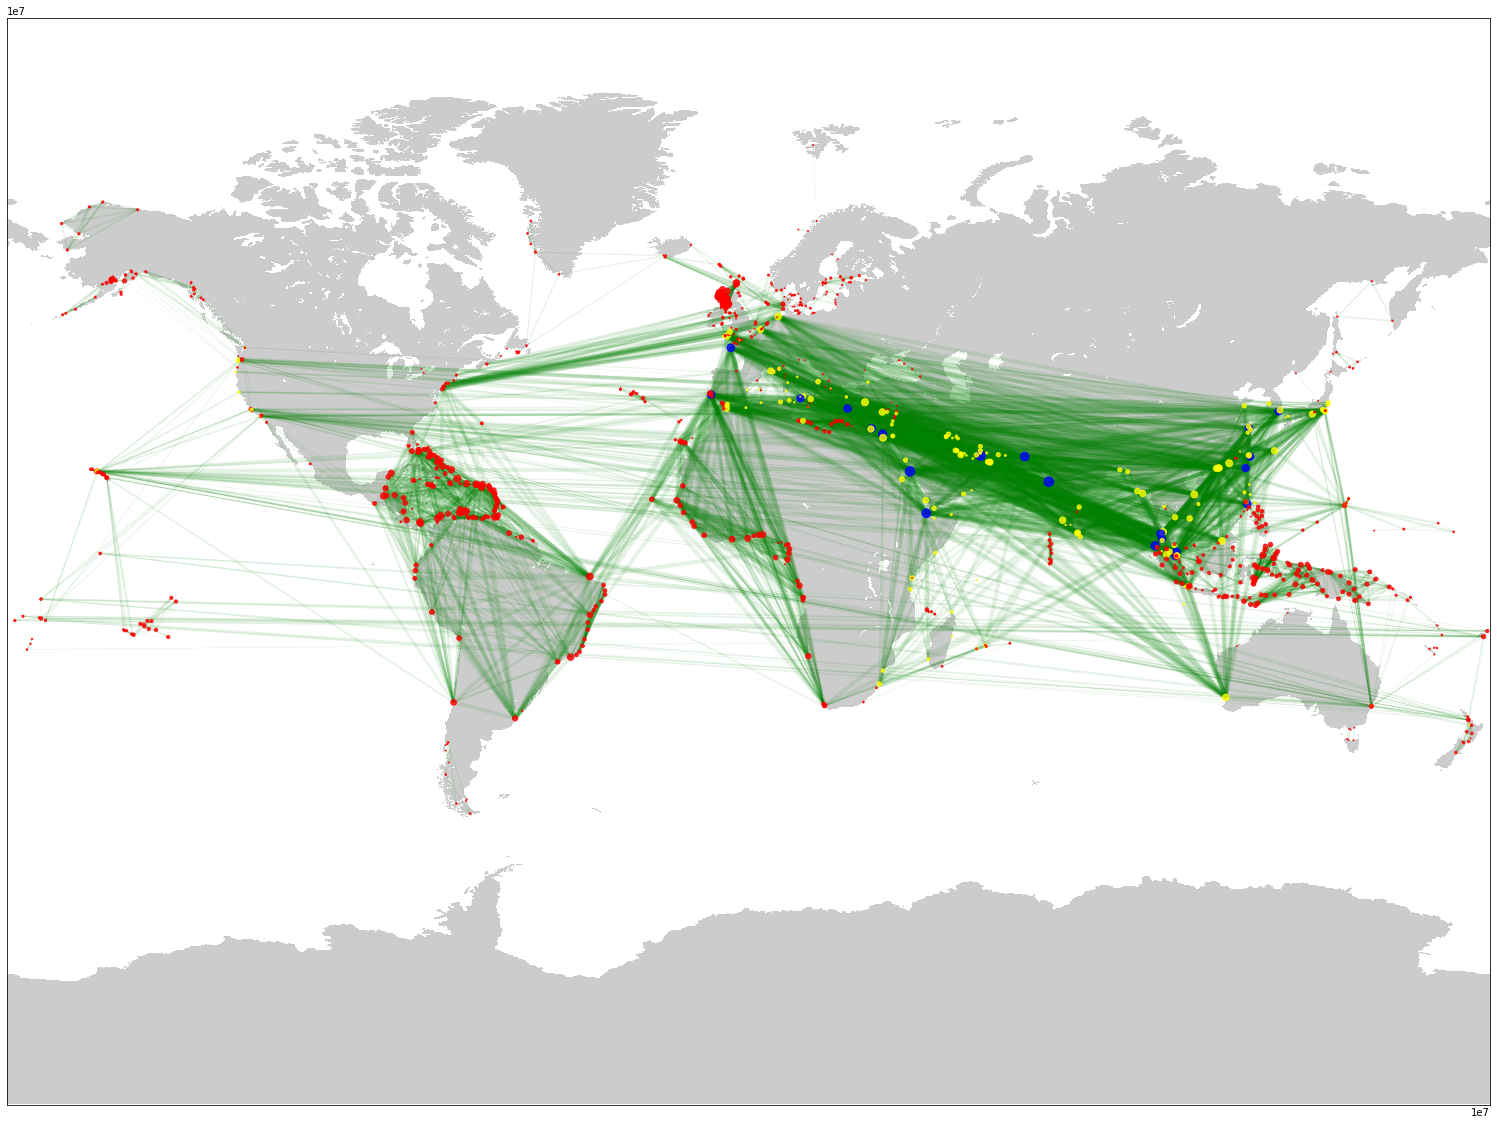

In [45]:
plt.figure(figsize=(30,20))
nx.draw_networkx_nodes(G = g, pos = pos, nodelist = g.nodes(), node_color = ['blue' if df8[df8.Name==s]['influ'].unique()=='yes' else 'yellow' if df8[df8.Name==s]['community_member'].unique()==0 else 'red' for s in g.nodes], alpha = 0.8,node_size = [df8[df8.source==s]['freq_city'].unique()[0] for s in g.nodes])
nx.draw_networkx_edges(G = g, pos = pos, edgelist = g.edges(), edge_color='g',alpha=0.1, arrows = False, width=[float(df8[df8['Name_cable']==s]['freq_cable'].max())/10 for s in df8.Name_cable])
m.drawlsmask()

In the above chart, I have highlighted the following information:
- Nodes:
    - the size is determined by the number of cables passing through that node
    - the color is yellow for the nodes that the community detection has highlighted as belonging to the most numerous and connected cluster, in blue the nodes labeled as "influencer" from the bivariate analysis; red for the others.
- Links:
    - the thickness of the link is determined by the number of cities through which that link passes: the "thicker" the line, the more the link encounters different cities.

From this first glance, what was previously reported by observing the various measures of centrality emerges: the most important nodes of this network all reside in Southeast Asia and Europe. Now let's take a deeper look inside Europe.

In [46]:
m2 = Basemap(projection='mill',resolution='l',suppress_ticks=False, llcrnrlon=-10, llcrnrlat=29, urcrnrlon=44, urcrnrlat=71)
mx2, my2 = m2(df8['longitude'].values, df8['latitude'].values)
pos2 = {}
for count, elem in enumerate (df8['source']):
    pos2[elem] = (mx2[count], my2[count])

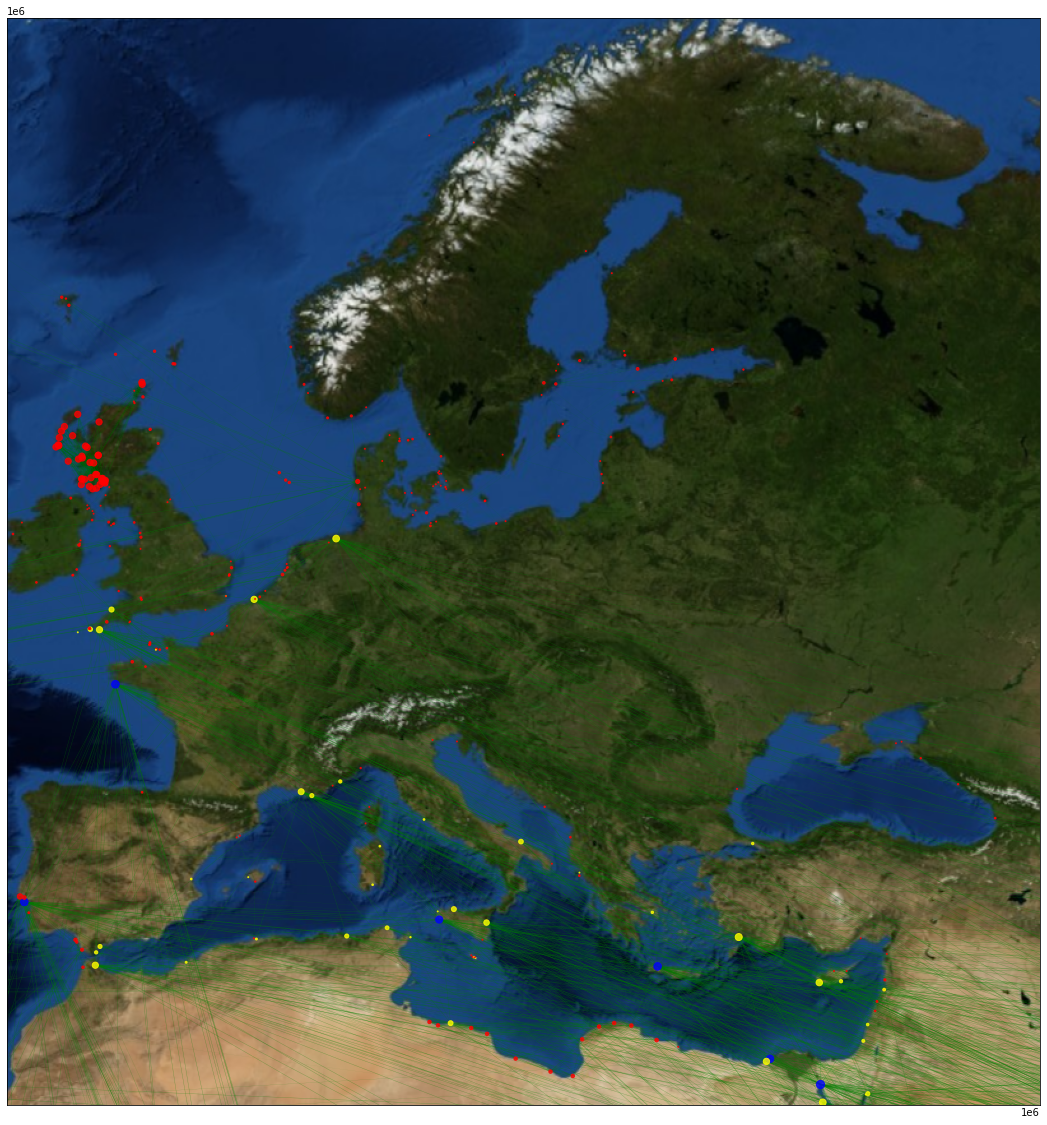

In [47]:
plt.figure(figsize=(30,20))
nx.draw_networkx_nodes(G = g, pos = pos2, nodelist = g.nodes(), node_color = ['blue' if df8[df8.Name==s]['influ'].unique()=='yes' else 'yellow' if df8[df8.Name==s]['community_member'].unique()==0 else 'red' for s in g.nodes], alpha = 0.8,node_size = [df8[df8.source==s]['freq_city'].unique()[0] for s in g.nodes])
nx.draw_networkx_edges(G = g, pos = pos2, edgelist = g.edges(), edge_color='g',alpha=0.4, arrows = False, width=[float(df8[df8['Name_cable']==s]['freq_cable'].max())/100 for s in df8.Name_cable])
m2.bluemarble()

In the map above is interesting to highlight the numerosity of yellow adn blue nodes in the area of the Mediterranea Sea. Moreover, in the north of England is highlithed a particular cluster, composed by a lot of not important nodes. 

# 5.0 Conclusion & further analysis

The aim of this work was to highlight which nodes are the most important for the network of undersea cables that allows the connection to the Internet on a global scale. 

From this first analysis it has emerged that the main nodes are located between Europe and Southeast Asia, with cables that run along the seabed of the Indian Ocean and arrive in the Mediterranean Sea. Consequently, creating a system to monitor these nodes could be useful to efficiently oversee the global Internet network.

The weaknesses of this project leave the door open for further and more in-depth analysis:
- enrich the dataset with more relevant information (data throughput, speed, adverse events)
- build predictive models able to classify the nodes most at risk, and so on.
- build scenario analysis, in order to be ready to act if something occur in the future (black swan)

**Note**: the graphical visualization offered is not faithful to the actual path of the nodes, which can be consulted at the following [link](https://www.submarinecablemap.com/) in an updated version: the dataset that it has been used was updated lastly only in 2018.

Thanks for your attention

Daniele D'Avino